In [ ]:
install.packages("tidyverse")
library(tidyverse)
install.packages("patchwork")
library(patchwork)

In [ ]:
if (!requireNamespace("RColorBrewer", quietly = TRUE)) {
  install.packages("RColorBrewer")
}

if (!requireNamespace("cowplot", quietly = TRUE)) {
  install.packages("cowplot")
}

library(dplyr)
library(tidyr)
library(ggplot2)
library(RColorBrewer)
library(cowplot) # Ensure the cowplot package is installed

In [ ]:
# Read the data from the CSV file
data <- read.csv("/content/RF-all_0.csv", stringsAsFactors = FALSE)

In [ ]:
head(data)

,Fold,Cluster,Features,Importance
,<int>,<int>,<chr>,<dbl>
1,1,1,d1_arterial_ph_avg,0.0401
2,1,2,d1_hemaglobin_avg,0.0103
3,1,2,d1_hematocrit_avg,0.0106
4,1,2,d1_potassium_avg,0.0110
5,1,2,d1_sysbp_diff,0.0111
6,1,3,d1_lactate_avg,0.0896


In [ ]:
data_wide <- data %>%
  pivot_wider(names_from = c(Fold, Cluster), values_from = Importance, values_fill = 0) %>%
  rename_with(~ gsub("_cluster", "_", .))

In [ ]:
head(data_wide)

Features,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,⋯,5_11,5_12,5_13,5_14,5_15,5_16,5_17,5_18,5_19,5_20
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
d1_arterial_ph_avg,0.0401,0.0000,0.0000,0,0,0,0,0,0,⋯,0,0,0,0,0,0.0000,0,0,0,0
d1_hemaglobin_avg,0.0000,0.0103,0.0000,0,0,0,0,0,0,⋯,0,0,0,0,0,0.0106,0,0,0,0
d1_hematocrit_avg,0.0000,0.0106,0.0000,0,0,0,0,0,0,⋯,0,0,0,0,0,0.0103,0,0,0,0
d1_potassium_avg,0.0000,0.0110,0.0000,0,0,0,0,0,0,⋯,0,0,0,0,0,0.0103,0,0,0,0
d1_sysbp_diff,0.0000,0.0111,0.0000,0,0,0,0,0,0,⋯,0,0,0,0,0,0.0110,0,0,0,0
d1_lactate_avg,0.0000,0.0000,0.0896,0,0,0,0,0,0,⋯,0,0,0,0,0,0.0000,0,0,0,0


In [ ]:
data_long <- data_wide %>%
  pivot_longer(-Features, names_to = "Fold_Cluster", values_to = "Importance") %>%
  separate(Fold_Cluster, into = c("Fold", "Cluster"), sep = "_")

In [ ]:
data_long <- data_long %>%
  group_by(Features) %>%
  mutate(MaxImportance = max(Importance)) %>%
  ungroup() %>%
  mutate(Feature = fct_reorder(Features, MaxImportance, .desc = FALSE)) %>%
  select(-MaxImportance)


In [ ]:
# Calculate the total importance of each Cluster within each Fold
cluster_importance <- data_long %>%
  group_by(Fold, Cluster) %>%
  summarise(TotalImportance = sum(Importance, na.rm = TRUE), .groups = 'drop')

# Obtain the ordering of Clusters within each Fold and assign new numbers
fold_levels <- cluster_importance %>%
  group_by(Fold) %>%
  arrange(Fold, desc(TotalImportance)) %>%
  mutate(NewCluster = row_number()) %>%
  ungroup()

# Redefine Cluster numbers
data_long_new_cluster <- data_long %>%
  left_join(fold_levels, by = c("Fold", "Cluster"))

# Print the redefined cluster data to check the results
print(head(data_long_new_cluster))
print(data_long_new_cluster %>%
  select(Fold, Cluster, NewCluster) %>%
  distinct() %>%
  arrange(Fold, NewCluster))

# A tibble: 6 × 7
  Features           Fold  Cluster Importance Feature TotalImportance NewCluster
  <chr>              <chr> <chr>        <dbl> <fct>             <dbl>      <int>
1 d1_arterial_ph_avg 1     1           0.0401 d1_art…          0.0401         10
2 d1_arterial_ph_avg 1     2           0      d1_art…          0.043           9
3 d1_arterial_ph_avg 1     3           0      d1_art…          0.0896          3
4 d1_arterial_ph_avg 1     4           0      d1_art…          0.0231         18
5 d1_arterial_ph_avg 1     5           0      d1_art…          0.0695          5
6 d1_arterial_ph_avg 1     6           0      d1_art…          0.0639          6
# A tibble: 100 × 3
   Fold  Cluster NewCluster
   <chr> <chr>        <int>
 1 1     13               1
 2 1     10               2
 3 1     3                3
 4 1     12               4
 5 1     5                5
 6 1     6                6
 7 1     9                7
 8 1     14               8
 9 1     2                9
10 1  

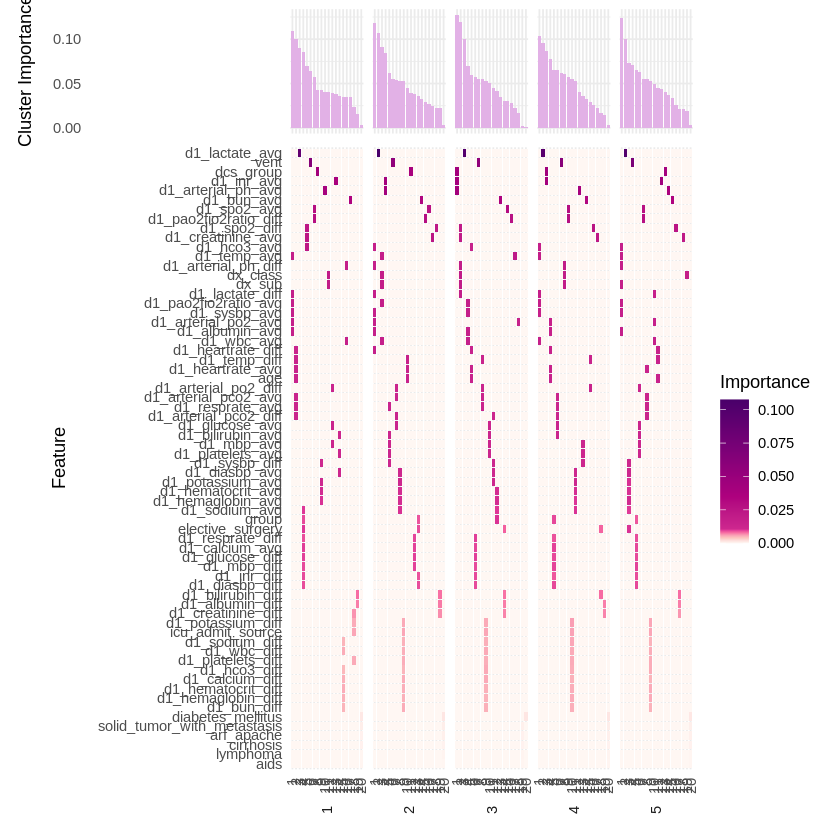

In [ ]:
# Create heatmap with adjusted color scale
heatmap_plot <- ggplot(data_long_new_cluster, aes(x = factor(NewCluster), y = Feature, fill = Importance)) +
  geom_tile(width = 0.9, height = 0.9) +
  scale_fill_gradientn(
    colors = brewer.pal(9, "RdPu"),
    values = scales::rescale(c(0, 5, 10, 100)) # Adjust the color distribution for better low value contrast
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    strip.text.x = element_text(angle = 90),
    strip.background = element_blank(),
    strip.placement = "outside",
    panel.grid.major.y = element_blank(),
    axis.line.x.top = element_line(),
    axis.ticks.x.top = element_line(),
    axis.title.x = element_blank() # Remove x-axis title
  ) +
  labs(
    y = "Feature",
    fill = "Importance"
  ) +
  facet_grid(. ~ Fold, switch = "x")

# Plot the bar chart of total importance for each Cluster within each Fold
cluster_importance_new_cluster <- data_long_new_cluster %>%
  group_by(Fold, NewCluster) %>%
  summarise(TotalImportance = sum(Importance), .groups = 'drop')

bar_chart_facet <- ggplot(cluster_importance_new_cluster, aes(x = factor(NewCluster), y = TotalImportance)) +
  geom_col(fill = "#e2b1e6") +
  facet_grid(. ~ Fold, scales = "free_x", space =  "free_x") +
  theme_minimal() +
  theme(
    axis.text.x = element_blank(),  # Remove x-axis labels
    axis.title.x = element_blank(),
    axis.ticks.x = element_blank(),
    strip.text.x = element_blank(), # Remove facet labels from the bar chart
    plot.margin = unit(c(0, 0, -0.25, 0), "cm"), # Adjust margins to place plots near each other
    panel.spacing.y = unit(0, "cm"), # Adjust the spacing between panels
    axis.title.y = element_text(margin = margin(r = 10)) # Add margin to the y-axis title
  ) +
  labs(x = "Cluster", y = "Cluster Importance")

# Combine plots using patchwork
combined_plot <- bar_chart_facet / heatmap_plot + plot_layout(heights = c(1, 5))

print(combined_plot)

In [ ]:
ggsave(
  filename = "Feature_Importance_Heatmap-RF-all.tiff",
  plot = combined_plot,
  device = "tiff",
  dpi = 300,  # Adjusted to a more typical high-resolution setting
  width = 15,
  height = 14,
  units = "in"
)
